# ANALISANDO E TRATADO DADOS DO CEAPS  

Neste trabalho foi usado um dataset coletado do portal do CEAPS (Cota para Exercício da Atividade Parlamentar dos Senadores). Nesse DataSet temos informações a respeito dos gastos declarados dos senadores. O objetivo deste tralho foi limpar e tratar os dados para realizar análises relacionadas aos gastos dos senadores.

1. Lendo o dataset e concatenado em um único Data Frame
2. Explorando o DATASET
3. DATA Cleaning
    - Limpando a coluna COD_DOCUMENTO
    - Limpando a coluna DATA
    - Limpando a coluna VALOR_REEMBOLSADO
    - Transformando a coluna DOCUMENTO em dados booleanos
    - Convertendo variáveis categóricas em variáveis dummies da coluna TIPO_DESPESA
    - Removendo as colunas que não participarão da análise dos dados

4. Análise dos dados
    - Explorando os valores dos gastos ao longo do tempo
        * Teste ADF
        * Autocorrelation Function
        * Partial autocorrelation function
    - Modelo SARIMAX
        * Grid search e a métrica AIC
        * Efetuando previsões
        * Cross validation



    


## Bibliotecas importadas

In [62]:
import pandas as pd
import warnings
import chardet
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import itertools
warnings.filterwarnings('ignore')

## 1. Lendo o dataset e concatenado em um único Data Frame

Para determinar o encoding do arquivo importaremos o `chardet.detect` e prosseguiremos da seguinte maneira:

In [63]:
with open('dados/despesa_ceaps_2019.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}

O provável encoding é `ISO-8859-1`, vamos usar essa informação no método `read_csv()` do Pandas e verificar se todos os arquivos do dataset serão lidos.

In [64]:
df_list=[]
isna_by_year=[]
anos = range(2008,2023)
for ano in anos:
    path='dados/despesa_ceaps_'+str(ano)+'.csv'
    df = pd.read_csv(path,sep=";",skiprows=1,encoding='ISO-8859-1')
    df_list.append(df)
    isna_by_year.append(df.isna().sum().values/df.shape[0])


Vamos concatenar todos os arquivos em um único data frame.

In [65]:
df = pd.concat(df_list, ignore_index=True)

## 2. Explorando o DATASET

Agora que temos todo o DataSet podemos fazer uma análise exploratória dos dados.

In [66]:
df.tail()

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
312592,2022,8,ZEQUINHA MARINHO,"Aluguel de imóveis para escritório político, c...",04.895.728/0001-80,EQUATORIAL ENERGIA,018516578,08/08/2022,NaN,"292,59",2186788.0
312593,2022,8,ZEQUINHA MARINHO,"Aluguel de imóveis para escritório político, c...",04.895.728/0001-80,EQUATORIAL ENERGIA,0202208018625090,08/08/2022,NaN,"553,33",2186787.0
312594,2022,8,ZEQUINHA MARINHO,"Locomoção, hospedagem, alimentação, combustíve...",27.522.923/0001-60,Casarao da Vila Restaurante LTDA - ME,000127032,03/08/2022,NaN,"26,57",2184892.0
312595,2022,8,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,FLXNAO,02/08/2022,"Companhia Aérea: GOL, Localizador: FLXNAO. Pas...","3140,46",2185426.0
312596,2022,8,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,TKR98A,07/08/2022,"Companhia Aérea: AZUL, Localizador: TKR98A. Pa...","2850,9",2185429.0


In [67]:
print('O dataframe df possui %d linhas e %d colunas'%(df.shape[0],df.shape[1]))

O dataframe df possui 312597 linhas e 11 colunas


O método `info()` do DataFrame mostra a quantidade de valores não nulos.

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312597 entries, 0 to 312596
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ANO                312597 non-null  int64  
 1   MES                312597 non-null  int64  
 2   SENADOR            312597 non-null  object 
 3   TIPO_DESPESA       312597 non-null  object 
 4   CNPJ_CPF           309453 non-null  object 
 5   FORNECEDOR         309453 non-null  object 
 6   DOCUMENTO          288099 non-null  object 
 7   DATA               309453 non-null  object 
 8   DETALHAMENTO       177658 non-null  object 
 9   VALOR_REEMBOLSADO  312597 non-null  object 
 10  COD_DOCUMENTO      312595 non-null  float64
dtypes: float64(1), int64(2), object(8)
memory usage: 26.2+ MB


Verificando se há valores NaN

In [69]:
df.isna().sum()

ANO                       0
MES                       0
SENADOR                   0
TIPO_DESPESA              0
CNPJ_CPF               3144
FORNECEDOR             3144
DOCUMENTO             24498
DATA                   3144
DETALHAMENTO         134939
VALOR_REEMBOLSADO         0
COD_DOCUMENTO             2
dtype: int64

Verificando se há valores Null

In [70]:
df.isnull().sum()

ANO                       0
MES                       0
SENADOR                   0
TIPO_DESPESA              0
CNPJ_CPF               3144
FORNECEDOR             3144
DOCUMENTO             24498
DATA                   3144
DETALHAMENTO         134939
VALOR_REEMBOLSADO         0
COD_DOCUMENTO             2
dtype: int64

Agora vamos criar uma lista com o nome das colunas que apresentam células com valores não numéricos

In [71]:
missing_data_columns=['DETALHAMENTO','CNPJ_CPF','DOCUMENTO','DATA','COD_DOCUMENTO','FORNECEDOR']

Fração de dados NaN para cada coluna e para cada ano

In [72]:
df_na=pd.DataFrame(isna_by_year, columns=df.columns)
df_na=df_na[missing_data_columns]
df_na.insert(0,'ANOS',anos)
df_na.tail(2)

,ANOS,DETALHAMENTO,CNPJ_CPF,DOCUMENTO,DATA,COD_DOCUMENTO,FORNECEDOR
13,2021,0.453200,0.0,0.040114,0.0,0.0,0.0
14,2022,0.466626,0.0,0.054485,0.0,0.0,0.0


## 3. DATA Cleaning

### Limpando a coluna COD_DOCUMENTO

Na sessão Explorando o Data set vimos que a coluna COD_DOCUMENTO apresentou problemas em apenas duas linhas.

In [73]:
df_tratado=df.copy()

In [74]:
na_index_list=np.where(df['COD_DOCUMENTO'].isna())[0]
for i in na_index_list:
    print(df.loc[i])
    print('\n')

ANO                                                               2015
MES                                                                  8
SENADOR                                                 EDUARDO AMORIM
TIPO_DESPESA         Passagens aéreas, aquáticas e terrestres nacio...
CNPJ_CPF                                            13.353.495/0001-84
FORNECEDOR                             PROPAGTUR - Propag Turismo Ltda
DOCUMENTO                                      SEM FATURA";02/08/2015"
DATA                 Companhia Aérea: TAM, Localizador: YXGDSJ. Pas...
DETALHAMENTO                                                    469,53
VALOR_REEMBOLSADO                                              2014675
COD_DOCUMENTO                                                      NaN
Name: 150213, dtype: object


ANO                                                               2015
MES                                                                  8
SENADOR                                        

Isso mostra que a Data está aparecendo na coluna DOCUMENTO. Precisamos separar esses dados cosiderando o ';' e realocar as informações nos lugares correstos.

In [75]:
for i in na_index_list:
    documento,data=df['DOCUMENTO'].loc[i].split(';')
    documento=documento.replace('\"','')
    data=data.replace('\"','')

    df_tratado['DOCUMENTO'].loc[i]=documento
    df_tratado['DATA'].loc[i]=data
    df_tratado['DETALHAMENTO'].loc[i]=df['DATA'].loc[i]
    df_tratado['VALOR_REEMBOLSADO'].loc[i]=df['DETALHAMENTO'].loc[i]
    df_tratado['COD_DOCUMENTO'].loc[i]=df['VALOR_REEMBOLSADO'].loc[i]

In [76]:
df_tratado.loc[na_index_list[1]]

ANO                                                               2015
MES                                                                  8
SENADOR                                                 EDUARDO AMORIM
TIPO_DESPESA         Passagens aéreas, aquáticas e terrestres nacio...
CNPJ_CPF                                            13.353.495/0001-84
FORNECEDOR                             PROPAGTUR - Propag Turismo Ltda
DOCUMENTO                                                 ¨¨SEM FATURA
DATA                                                        17/08/2015
DETALHAMENTO         Companhia Aérea: AVIANCA, Localizador: ZNEU9F....
VALOR_REEMBOLSADO                                               460,45
COD_DOCUMENTO                                                  2016557
Name: 150220, dtype: object

In [77]:
i=1
print(df_tratado.loc[na_index_list[i]])

ANO                                                               2015
MES                                                                  8
SENADOR                                                 EDUARDO AMORIM
TIPO_DESPESA         Passagens aéreas, aquáticas e terrestres nacio...
CNPJ_CPF                                            13.353.495/0001-84
FORNECEDOR                             PROPAGTUR - Propag Turismo Ltda
DOCUMENTO                                                 ¨¨SEM FATURA
DATA                                                        17/08/2015
DETALHAMENTO         Companhia Aérea: AVIANCA, Localizador: ZNEU9F....
VALOR_REEMBOLSADO                                               460,45
COD_DOCUMENTO                                                  2016557
Name: 150220, dtype: object


### Limpando a coluna DATA

Observamos na tabela abaixo que aproximadamente 1% dos dados são NaN para a coluna DATA.

In [78]:
df_tratado.isna().sum()/df_tratado.shape[0]

ANO                  0.000000
MES                  0.000000
SENADOR              0.000000
TIPO_DESPESA         0.000000
CNPJ_CPF             0.010058
FORNECEDOR           0.010058
DOCUMENTO            0.078369
DATA                 0.010058
DETALHAMENTO         0.431671
VALOR_REEMBOLSADO    0.000000
COD_DOCUMENTO        0.000000
dtype: float64

In [79]:
#convertendo data de objetc para datetime
df_tratado["DATA"]=pd.to_datetime(df_tratado["DATA"], errors='coerce')
#Estimando data de valores nan com as colunas ano e mes
where_is_na=np.where(df_tratado["DATA"].isna())[0]
new_date=pd.to_datetime(df_tratado.ANO.astype(str) + '/' + df_tratado.MES.astype(str)+'/01')
for i in where_is_na:
    df_tratado["DATA"].loc[i]=new_date[i]

In [80]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312597 entries, 0 to 312596
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ANO                312597 non-null  int64         
 1   MES                312597 non-null  int64         
 2   SENADOR            312597 non-null  object        
 3   TIPO_DESPESA       312597 non-null  object        
 4   CNPJ_CPF           309453 non-null  object        
 5   FORNECEDOR         309453 non-null  object        
 6   DOCUMENTO          288099 non-null  object        
 7   DATA               312597 non-null  datetime64[ns]
 8   DETALHAMENTO       177658 non-null  object        
 9   VALOR_REEMBOLSADO  312597 non-null  object        
 10  COD_DOCUMENTO      312597 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 26.2+ MB


In [81]:
df_tratado["DATA"]=pd.to_datetime(df_tratado['DATA'])

In [82]:
#pegando a coluna DATA
data=pd.to_datetime(df_tratado['DATA'])#.dt.date
#Pegando apenas os anos referentes a data
anos_data=[a.year for a in data]
#Pegando apenas os anos referentes ao período
anos_periodo=df_tratado["ANO"]
np.unique(anos)


array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022])

In [83]:
u=((anos_data-anos_periodo)==0).sum()
print("Temos que em %.0f porcento dos dados a direferença entre ano da data e ano do período é zero."%(u*100/df_tratado.shape[0]))

Temos que em 99 porcento dos dados a direferença entre ano da data e ano do período é zero.


In [84]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312597 entries, 0 to 312596
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ANO                312597 non-null  int64         
 1   MES                312597 non-null  int64         
 2   SENADOR            312597 non-null  object        
 3   TIPO_DESPESA       312597 non-null  object        
 4   CNPJ_CPF           309453 non-null  object        
 5   FORNECEDOR         309453 non-null  object        
 6   DOCUMENTO          288099 non-null  object        
 7   DATA               312597 non-null  datetime64[ns]
 8   DETALHAMENTO       177658 non-null  object        
 9   VALOR_REEMBOLSADO  312597 non-null  object        
 10  COD_DOCUMENTO      312597 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 26.2+ MB


Agora vamos concatenar as colunas 'ANO' e 'MES' na coluna 'PERIODO'

In [85]:
ano_mes=pd.to_datetime(df_tratado.ANO.astype(str) + '/' + df_tratado.MES.astype(str) ).dt.to_period('M')
df_tratado.insert(0,'PERIODO',ano_mes)
df_tratado.tail()

,PERIODO,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
312592,2022-08,2022,8,ZEQUINHA MARINHO,"Aluguel de imóveis para escritório político, c...",04.895.728/0001-80,EQUATORIAL ENERGIA,018516578,2022-08-08,NaN,"292,59",2186788.0
312593,2022-08,2022,8,ZEQUINHA MARINHO,"Aluguel de imóveis para escritório político, c...",04.895.728/0001-80,EQUATORIAL ENERGIA,0202208018625090,2022-08-08,NaN,"553,33",2186787.0
312594,2022-08,2022,8,ZEQUINHA MARINHO,"Locomoção, hospedagem, alimentação, combustíve...",27.522.923/0001-60,Casarao da Vila Restaurante LTDA - ME,000127032,2022-03-08,NaN,"26,57",2184892.0
312595,2022-08,2022,8,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,FLXNAO,2022-02-08,"Companhia Aérea: GOL, Localizador: FLXNAO. Pas...","3140,46",2185426.0
312596,2022-08,2022,8,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,TKR98A,2022-07-08,"Companhia Aérea: AZUL, Localizador: TKR98A. Pa...","2850,9",2185429.0


### Limpando a coluna VALOR_REEMBOLSADO

Outra informação importante que tiramos do data frame usando o método `df.info()` é que a coluna VALOR_REEMBOLSADO não está sendo lida como sendo de um tipo numérico, mas sim como sendo do tipo object. Portanto, vamos converter a coluna VALOR_REEMBOLSADO para valor numérico da seguinte maneira:

In [86]:
valor_remb=pd.to_numeric(df_tratado['VALOR_REEMBOLSADO'].str.replace(',','.'), errors='coerce')
where_is_na=np.where(valor_remb.isna())[0]

print("Temos que %d de %d valores não foram convertidos para numero."%(len(where_is_na),df_tratado.shape[0]))

Temos que 1 de 312597 valores não foram convertidos para numero.


In [87]:
print(where_is_na)
df_tratado.loc[where_is_na[0]]

[115962]


PERIODO                                                        2013-02
ANO                                                               2013
MES                                                                  2
SENADOR                                                RICARDO FERRAÇO
TIPO_DESPESA         Passagens aéreas, aquáticas e terrestres nacio...
CNPJ_CPF                                            02.012.862/0001-60
FORNECEDOR                                                         TAM
DOCUMENTO                                                9572462859757
DATA                                               2013-04-02 00:00:00
DETALHAMENTO         CNPJ: 02.012.862/0001-60 FORNECEDOR: TAM DOCUM...
VALOR_REEMBOLSADO                                          1\r\n675,55
COD_DOCUMENTO                                                 698982.0
Name: 115962, dtype: object

In [88]:
valor_remb[where_is_na[0]]=675.55
df_tratado['VALOR_REEMBOLSADO']=valor_remb
df_tratado['VALOR_REEMBOLSADO'].describe()

count    312597.000000
mean       1005.278140
std        2561.660456
min       -1500.000000
25%         100.000000
50%         280.000000
75%         994.080000
max      270000.000000
Name: VALOR_REEMBOLSADO, dtype: float64

O método `describe()` revelou que há valores negativos na coluna 'VALOR_REEMBOLSADO'. Portanto vamos investigar esses valores e o que podemos fazer sobre isso.

In [89]:
negativos=np.where(valor_remb<0)[0]
print("A coluna 'VALOR_REEMBOLSADO' apresentou %d valores negativos"%(len(negativos)),'\n')

A coluna 'VALOR_REEMBOLSADO' apresentou 3 valores negativos 



Como exitem poucos valores negativos, vamos olhá-los individualmente.

In [90]:
for i in negativos:
    print(df.loc[i],'\n')

ANO                                                               2015
MES                                                                  2
SENADOR                                                 GLADSON CAMELI
TIPO_DESPESA         Aluguel de imóveis para escritório político, c...
CNPJ_CPF                                            63.600.449/0001-00
FORNECEDOR           Arras Adm. de Bens Imóveis Limpeza e Conservaç...
DOCUMENTO                                                          NaN
DATA                                                        15/01/2015
DETALHAMENTO         Contrato de locação de Imóvel comercial do esc...
VALOR_REEMBOLSADO                                                -1500
COD_DOCUMENTO                                                2001228.0
Name: 152315, dtype: object 

ANO                                                               2015
MES                                                                  1
SENADOR                                        

In [91]:
for i in negativos:
    print(df['DETALHAMENTO'].loc[i],'\n')
    

Contrato de locação de Imóvel comercial do escritório de apoio do Senador Gladson Cameli no Estado 

9572100929351 - R$ 1.298,93 (1º bilhete emitido) 9572102224403 - R$ 1.418,93 (1ª remarcação) 9572104023443 - R$ 1.498,93 (2ª remarcação) 9572104373256 - R$ 2.412,03 (3ª remarcação - bilhete utilizado) 

Despesa com Monitoramento de Informação Jornalística em Mídia Eletrônica e Imprensa 



Como não conseguimos inferir um novo número para essas linhas iremos excluí-las.

In [92]:
df_tratado=df_tratado.drop(index=negativos).reset_index()

Agora vamos verificar as correções feitas usando o método `info()`.

In [93]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312594 entries, 0 to 312593
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   index              312594 non-null  int64         
 1   PERIODO            312594 non-null  period[M]     
 2   ANO                312594 non-null  int64         
 3   MES                312594 non-null  int64         
 4   SENADOR            312594 non-null  object        
 5   TIPO_DESPESA       312594 non-null  object        
 6   CNPJ_CPF           309450 non-null  object        
 7   FORNECEDOR         309450 non-null  object        
 8   DOCUMENTO          288097 non-null  object        
 9   DATA               312594 non-null  datetime64[ns]
 10  DETALHAMENTO       177655 non-null  object        
 11  VALOR_REEMBOLSADO  312594 non-null  float64       
 12  COD_DOCUMENTO      312594 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), 

### Transformando a coluna DOCUMENTO em dados booleanos
Vamos transformar a coluna DOCUMENTO em dados booleanos, de modo que o valor True representa a situação em que o senador incluiu o documento e o False representa que o senador não o incluiu.

In [94]:
df_tratado['DOCUMENTO']=pd.to_numeric(df_tratado['DOCUMENTO'].isna()==False)
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312594 entries, 0 to 312593
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   index              312594 non-null  int64         
 1   PERIODO            312594 non-null  period[M]     
 2   ANO                312594 non-null  int64         
 3   MES                312594 non-null  int64         
 4   SENADOR            312594 non-null  object        
 5   TIPO_DESPESA       312594 non-null  object        
 6   CNPJ_CPF           309450 non-null  object        
 7   FORNECEDOR         309450 non-null  object        
 8   DOCUMENTO          312594 non-null  bool          
 9   DATA               312594 non-null  datetime64[ns]
 10  DETALHAMENTO       177655 non-null  object        
 11  VALOR_REEMBOLSADO  312594 non-null  float64       
 12  COD_DOCUMENTO      312594 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), i

### Convertendo variáveis categóricas em variáveis dummies da coluna TIPO_DESPESA	

Convertendo variáveis categóricas em variáveis dummies conseguimos gerar novas colunas com informações  sobre os tipos de despesa que podem ser analisadas.

In [95]:
dummies=pd.get_dummies(df_tratado['TIPO_DESPESA'])
col=dummies.columns
dummies=pd.get_dummies(df_tratado['TIPO_DESPESA'])
dummies.head(2)

,"Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.","Aquisição de material de consumo para uso no escritório político, inclusive aquisição ou locação de software, despesas postais, aquisição de publicações, locação de móveis e de equipamentos.","Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar",Divulgação da atividade parlamentar,"Locomoção, hospedagem, alimentação, combustíveis e lubrificantes","Passagens aéreas, aquáticas e terrestres nacionais",Serviços de Segurança Privada
0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0


Como os nomes das colunas estão muito extensos, farei um dicionário para esses nomes da seguinte maneira:
 
* **DESPESA_0**: Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.
* **DESPESA_1**: Aquisição de material de consumo para uso no escritório político, inclusive aquisição ou locação de software, despesas postais, aquisição de publicações, locação de móveis e de equipamentos. 
* **DESPESA_2**: Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar
* **DESPESA_3**: Divulgação da atividade parlamentar
* **DESPESA_4**: Locomoção, hospedagem, alimentação, combustíveis e lubrificantes
* **DESPESA_5**: Passagens aéreas, aquáticas e terrestres nacionais
* **DESPESA_6**: Serviços de Segurança Privada

In [96]:
dict_col={}
for i in range(len(col)):
    dict_col[col[i]]='DESPESA_'+str(i)
dummies=dummies.rename(columns=dict_col)
dummies.head(2)

,DESPESA_0,DESPESA_1,DESPESA_2,DESPESA_3,DESPESA_4,DESPESA_5,DESPESA_6
0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0


In [97]:
df_tratado=pd.concat([df_tratado,dummies],axis=1)
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312594 entries, 0 to 312593
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   index              312594 non-null  int64         
 1   PERIODO            312594 non-null  period[M]     
 2   ANO                312594 non-null  int64         
 3   MES                312594 non-null  int64         
 4   SENADOR            312594 non-null  object        
 5   TIPO_DESPESA       312594 non-null  object        
 6   CNPJ_CPF           309450 non-null  object        
 7   FORNECEDOR         309450 non-null  object        
 8   DOCUMENTO          312594 non-null  bool          
 9   DATA               312594 non-null  datetime64[ns]
 10  DETALHAMENTO       177655 non-null  object        
 11  VALOR_REEMBOLSADO  312594 non-null  float64       
 12  COD_DOCUMENTO      312594 non-null  object        
 13  DESPESA_0          312594 non-null  uint8   

### Removendo as colunas que não participarão da análise dos dados
* **'ANO' e 'MES'**
    - As colunas 'ANO' e 'MES' foram concatenadas na colunas 'PERIODO'

* **'DETALHAMENTO'**
    - A coluna 'DETALHAMENTO' te muitos valores ausentes e não será usada nas análises.
    
* **'COD_DOCUMENTO'**
    - A coluna 'COD_DOCUMENTO' possuem informação que não serão úteis nas análises.
    
* **'CNPJ_CPF' e 'FORNECEDOR'**
    - Como vimos, quando estavamos explorando os dados, as colunas 'CNPJ_CPF', 'FORNECEDOR' e 'DATA' não apareceram apenas em 2008 e em parte de 2009, de modo que não seria interessante transformar os dados 'CNPJ_CPF' e 'FORNECEDOR' em dados booleanos. 
 
* **'TIPO_DESPESA'**
    - A coluna 'TIPO_DESPESA' não é mais necessária pois foi transformada em colunas com variáveis dummy.

In [98]:
remove_columns=['ANO','MES','DETALHAMENTO','COD_DOCUMENTO','CNPJ_CPF','FORNECEDOR','TIPO_DESPESA']
df_tratado=df_tratado.drop(remove_columns,axis=1)

In [99]:
df_tratado.head(2)

,index,PERIODO,SENADOR,DOCUMENTO,DATA,VALOR_REEMBOLSADO,DESPESA_0,DESPESA_1,DESPESA_2,DESPESA_3,DESPESA_4,DESPESA_5,DESPESA_6
0,0,2008-09,ADA MELLO,False,2008-09-01,12351.52,0,0,1,0,0,0,0
1,1,2008-09,ADA MELLO,False,2008-09-01,386.60,0,0,0,0,1,0,0


In [100]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312594 entries, 0 to 312593
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   index              312594 non-null  int64         
 1   PERIODO            312594 non-null  period[M]     
 2   SENADOR            312594 non-null  object        
 3   DOCUMENTO          312594 non-null  bool          
 4   DATA               312594 non-null  datetime64[ns]
 5   VALOR_REEMBOLSADO  312594 non-null  float64       
 6   DESPESA_0          312594 non-null  uint8         
 7   DESPESA_1          312594 non-null  uint8         
 8   DESPESA_2          312594 non-null  uint8         
 9   DESPESA_3          312594 non-null  uint8         
 10  DESPESA_4          312594 non-null  uint8         
 11  DESPESA_5          312594 non-null  uint8         
 12  DESPESA_6          312594 non-null  uint8         
dtypes: bool(1), datetime64[ns](1), float64(1), i

Agora temos nossos dados limpos e prontos para análises!

## 4. Análise dos dados

### Explorando os valores dos gastos ao longo do tempo

Temos como objetivo fazer uma análise exploratória para nos ajudar na criação de um modelo para esta série temporal. Para isso, consideraremos apenas dados a partir de 2018.


In [101]:
df_filtrado=df_tratado[['PERIODO','VALOR_REEMBOLSADO']]
df_filtrado=df_filtrado[df_tratado['PERIODO']>'2018-01-01'].groupby('PERIODO').sum()
df_filtrado.tail()


,VALOR_REEMBOLSADO
PERIODO,
2022-05,2466599.08
2022-06,2094922.43
2022-07,2013869.35
2022-08,1571113.25
2022-09,353477.49


In [102]:
#criando uma lista de strings com as datas
datas=[(str(x.year)+'-'+('%02d'%(x.month)) ) for x in df_filtrado.index]
len(datas)

56

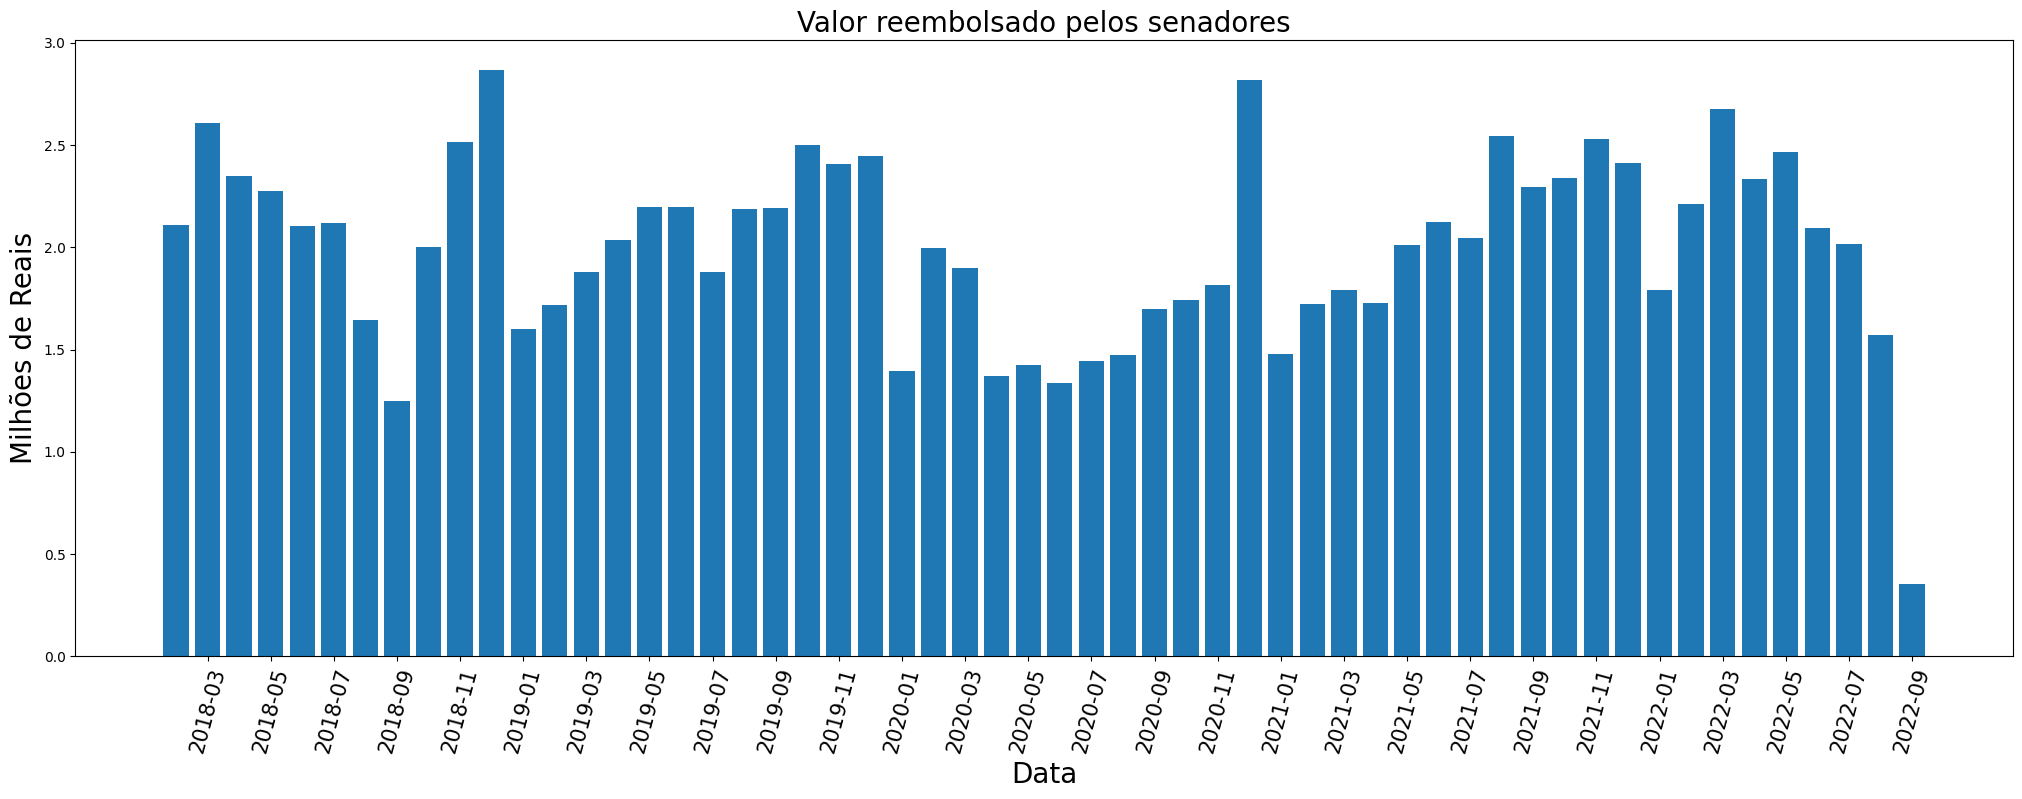

In [103]:
plt.figure(figsize=(25,8))
fig = plt.bar(datas,df_filtrado.VALOR_REEMBOLSADO/10**6)
plt.title("Valor reembolsado pelos senadores", size = 20)
plt.xlabel("Data",size=20)
plt.ylabel('Milhões de Reais',size=20)
plt.xticks(np.arange(1,len(datas),2),rotation=75,size=15)
plt.show()

Usando o método barplot do seaborn, conseguimos observar as médias de gastos dos senadores, com as linhas verticais representando o intervalo de confiança.

Text(0.5, 1.0, 'Valor reembolsado pelos senadores em cada mês \n considerando os anos --')

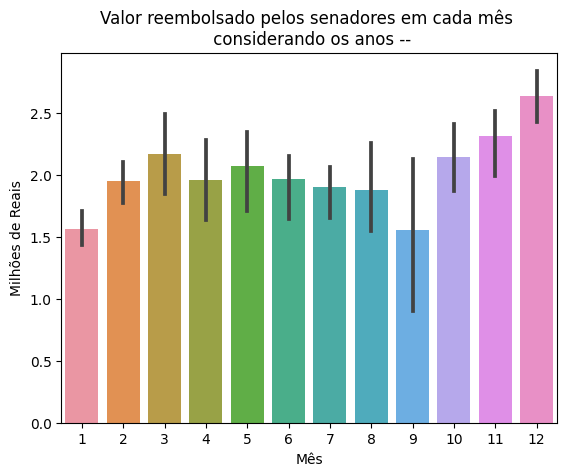

In [104]:
sns.barplot(x=df_filtrado.index.month,y=df_filtrado.VALOR_REEMBOLSADO.values/10**6)
plt.xlabel('Mês')
plt.ylabel('Milhões de Reais')
plt.title('Valor reembolsado pelos senadores em cada mês \n considerando os anos --')



É natural escolhermos uma frequência de 12 meses para os dados. Com isso, faremos a decomposição dos valores observados entre a tendência e sazonalidade apresentadas.

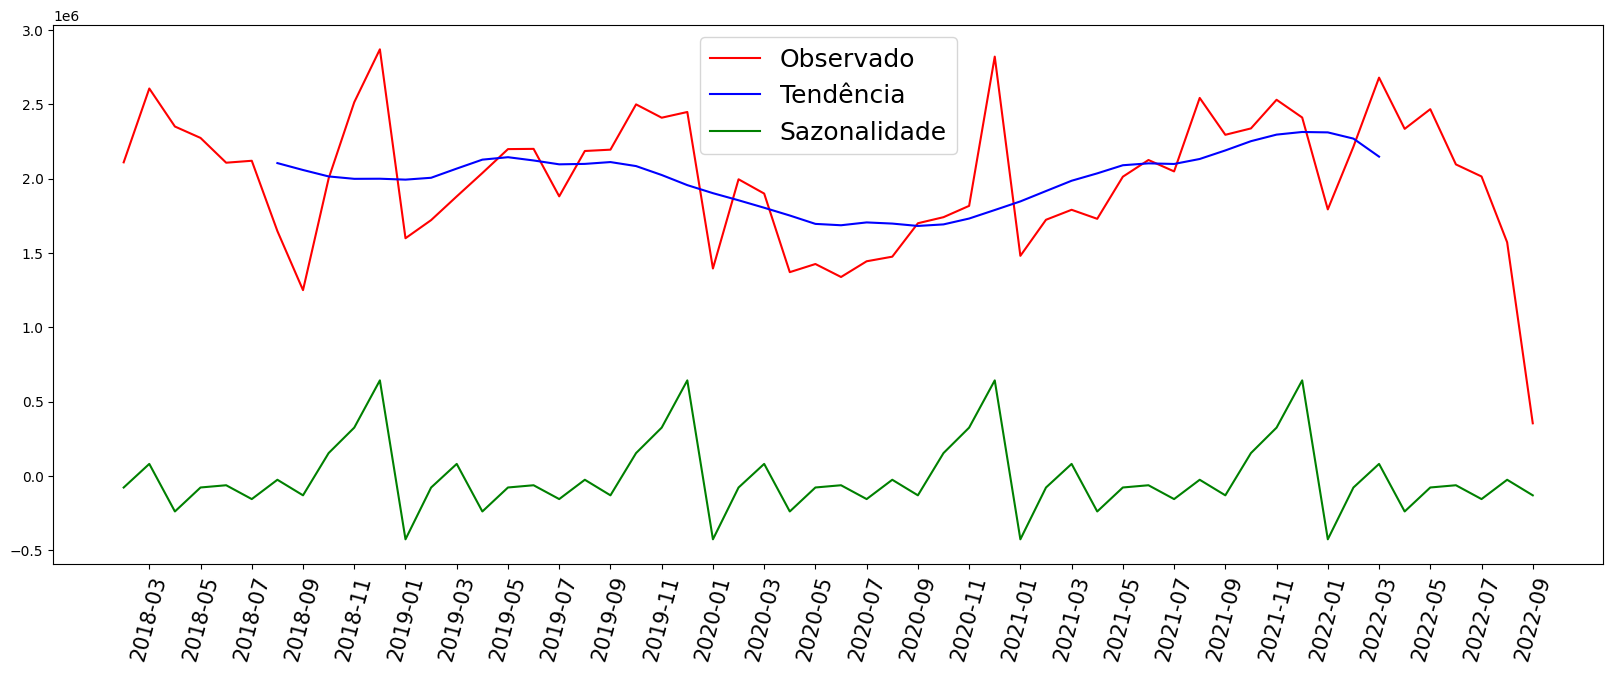

In [105]:
resultados = seasonal_decompose(df_filtrado.VALOR_REEMBOLSADO,period=12)
resultados

plt.figure(figsize=(20,7))
plt.plot(datas,resultados.observed.values,color='red',label='Observado')
plt.plot(datas,resultados.trend.values,color='blue',label='Tendência')
plt.plot(datas,resultados.seasonal.values,color='green',label='Sazonalidade')
plt.legend(fontsize=18)
plt.xticks(np.arange(1,len(datas),2),rotation=75,size=15)
plt.show()
    



Para facilitar a notação criaremos a variável y com o valor reembolsado.

In [106]:
y = df_filtrado['VALOR_REEMBOLSADO']
y.head()

PERIODO
2018-02    2108974.19
2018-03    2605619.03
2018-04    2349894.82
2018-05    2273119.95
2018-06    2106459.89
Freq: M, Name: VALOR_REEMBOLSADO, dtype: float64

#### Teste ADF

Para verificar a estacionariedade da série aplicaremos o teste de Augmented Dickey-Fuller (ADF). A hipótese nula consiste na existência de não estacionariedade na série e a hipótese alternativa consiste na existência de estacionariedade.

In [107]:

print(adfuller(y.dropna()))
print('p-valor:',adfuller(y.dropna())[1] )

(-3.528246160119165, 0.0072906230728153176, 0, 55, {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}, 1263.6768394019484)
p-valor: 0.0072906230728153176


Segundo o teste ADF, quando o p-valor está abaixo de 0.05, podemos rejeitar a hipotese nula com um nível de confiança de 95%, de modo que nossa série será considerada estacionária. Como vimos acima, nosso p-valor é de aproximadamente 0.005.  No entanto, ainda sim, sabemos que existe uma sazonalidade.

#### Autocorrelation Function

Quando computamos a ACF, ou seja Autocorrelation Function, muitas vezes vimos uma tendência, que pode desaparecer com a diferenciação da série. Dessa forma, removemos a componente de autocorrelação e é por isso que conseguimos transformar a serie temporal em uma série estacionária.

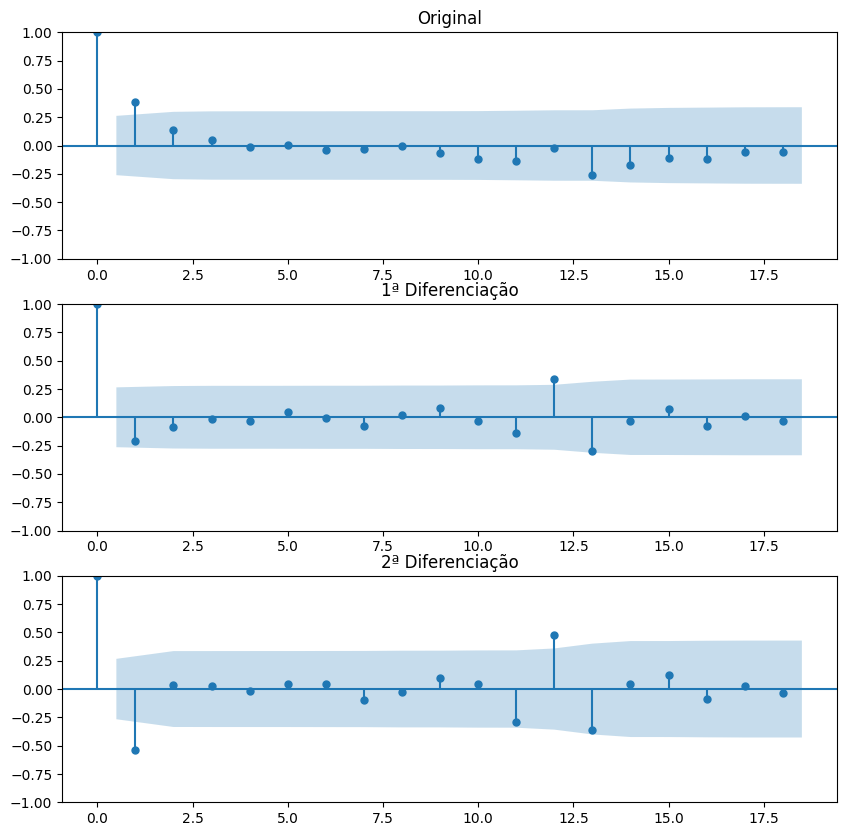

In [108]:
def plotarACF(y1,y2,y3):
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(311)#3 linhas, 1 coluna, graph 1
    fig = plot_acf(y1,ax=ax1,title='Original')
    ax2 = fig.add_subplot(312)#3 linhas, 1 coluna, graph 2
    fig = plot_acf(y2,ax=ax2,title='1ª Diferenciação')
    ax3 = fig.add_subplot(313)#3 linhas, 1 coluna, graph 2
    fig = plot_acf(y3,ax=ax3,title='2ª Diferenciação')
    plt.show()
plotarACF(y,y.diff().dropna(),y.diff().diff().dropna())

#### Partial autocorrelation function

A PACF, ou seja, Partial autocorrelation function, representa os valores que ficam após removermos os efeitos já explicados pelos lags anteriores. Se existir qualquer informação residual importante, vamos identificar com a autocorrelação parcial.

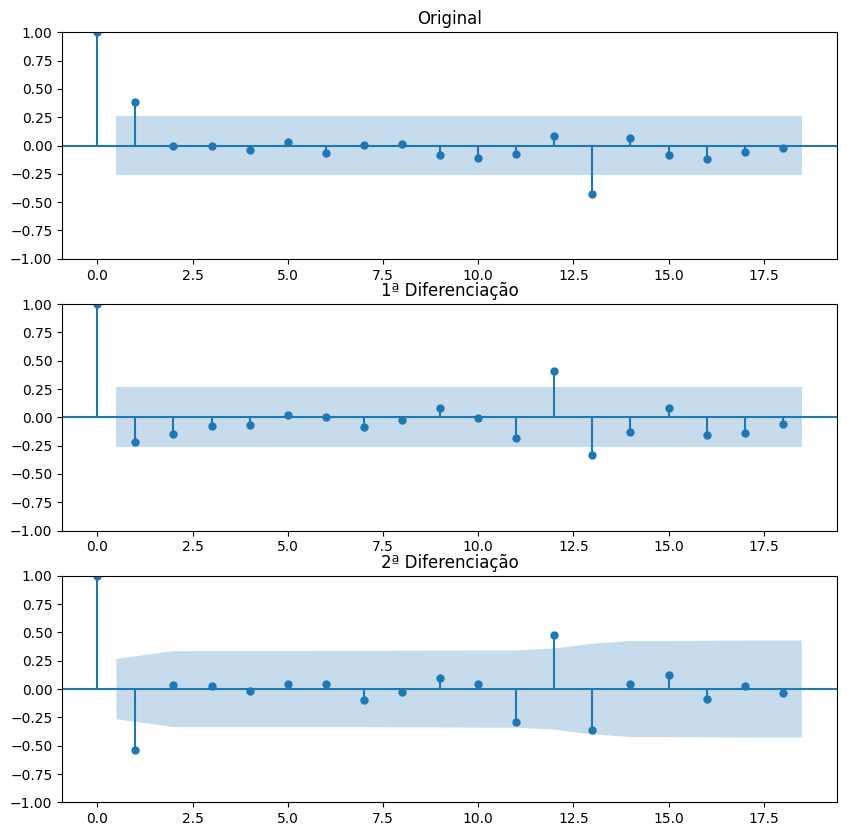

In [109]:
def plotarPACF(y1,y2,y3):
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(311)#3 linhas, 1 coluna, graph 1
    fig = plot_pacf(y1,ax=ax1,title='Original')
    ax2 = fig.add_subplot(312)#3 linhas, 1 coluna, graph 2
    fig = plot_pacf(y2,ax=ax2,title='1ª Diferenciação')
    ax3 = fig.add_subplot(313)#3 linhas, 1 coluna, graph 2
    fig = plot_acf(y3,ax=ax3,title='2ª Diferenciação')
    plt.show()
plotarPACF(y,y.diff().dropna(),y.diff().diff().dropna())


Conhecendo os dados, e observando os gáficos de PACF conseguimos identificar a sazonalidade de 12 meses quando observamos o lag 12 com um valor acima do intervalo de confiança. 

### Modelo SARIMAX

Usaremos o modelo SARIMAX (Sazonal autorregressivo Integrado de Médias Móveis com Covariáveis), pois identificamos sazonalidade e consideraremos efeitos exogenos, ou seja, consideraremos variáveis externas que podem influenciar na previsão.


#### Grid search e a métrica AIC

O modelo SARIMAX precisa dos (p, d, q) devido ao modelo ARIMA, e os parâmetros (P, D, Q) devido a sazonalidade.
* p é o número de termos da regressão.
* d é o número de vezes que diferenciamos a série para deixá-la estacionárias.
* q ordem da média móvel.
    

In [110]:

p=d=q=range(0,2)
pdq = list(itertools.product(p, d, q))
pdq[:10]

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [111]:
seasonal_pdq = [(x[0],x[1],x[2],12) for x in pdq]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [112]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


**AIC** significa critério de informação arcaic e ele basicamente vai comparar o resultado que você obteve com os dados observádos, através de uma métrica de distância. De modo que, quanto menor o valor do AIC melhor foi o fit.

In [113]:

aic_lista = []
par_lista = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(y,
                                       order=param,
                                       seasonal_order=param_seasonal)
        results = mod.fit()
        par_lista.append('ARIMA{}x{} - AIC {}'.format(param, param_seasonal, results.aic))
        aic_lista.append(results.aic)

In [114]:
par_lista[aic_lista.index(min(aic_lista))]


'ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC 1231.3453145114192'

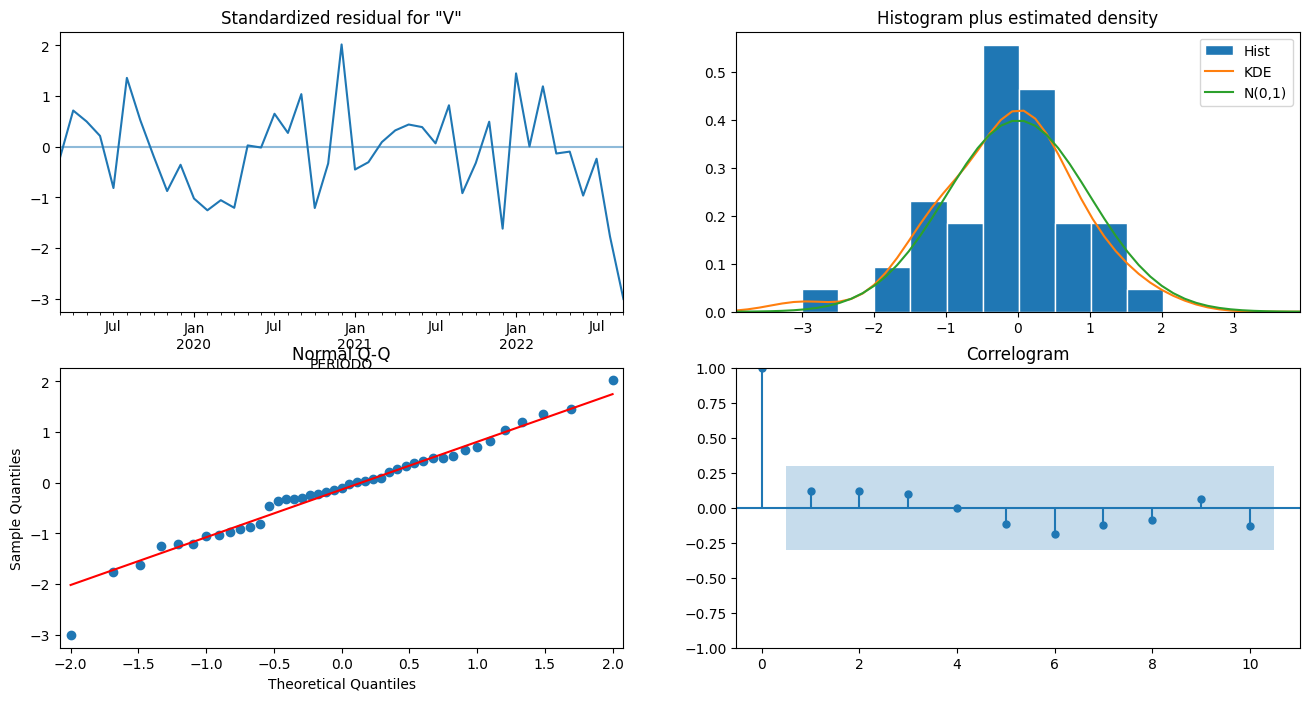

In [115]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order = (0, 1, 0),
                               seasonal_order=(1, 1, 0, 12))#sazonalidade
results = mod.fit()
results.plot_diagnostics(figsize=(16,8))
plt.show()

No primeiro gráfico temos os resíduos, onde conseguimos tirar uma impressão inicial de como eles estão distribuídos. 

No histograma temos o KDE, que é a distribuição dos resíduos. Queremos que essa distribuição seja uma normal,que está representado por N(0,1). Com isso vemos que os erros aparentam ter uma distribuição aproximadamente normal que não apresenta grandes deformidades para a esquerda ou para a direita.

No correlogram, onde vemos as autocorrelações residuais, vemos que o nosso modelo conseguiu transformar nossa série temporal em uma série estacionária.

#### Efetuando previsões

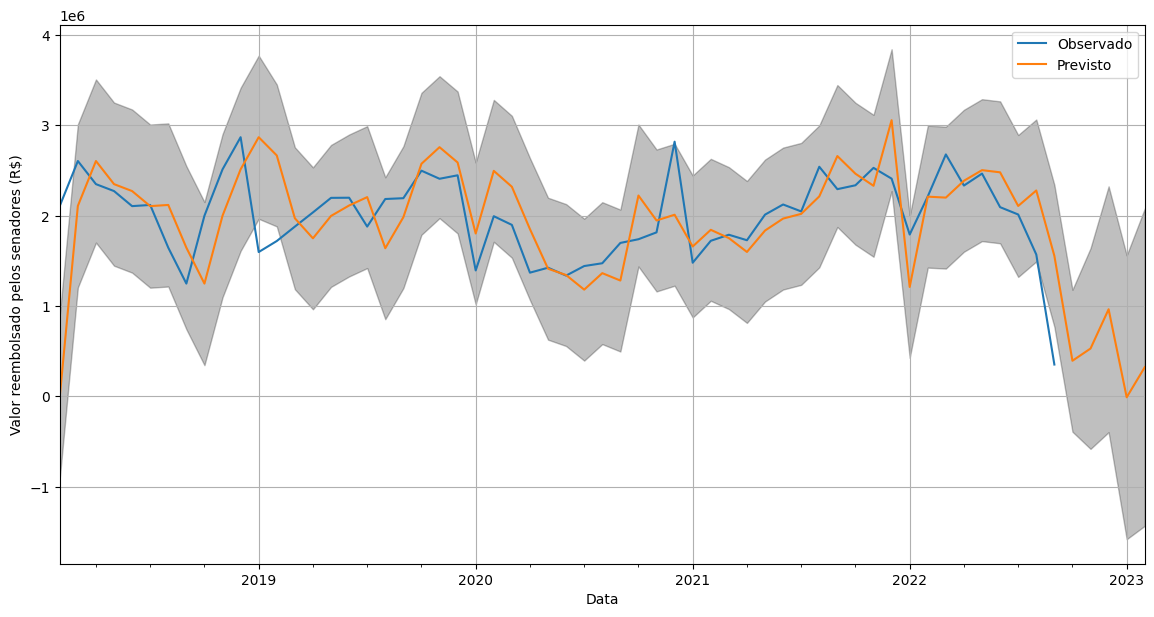

In [116]:
#Previsões dentro da amostra e fora da amostra
pred=results.get_prediction(end=pd.to_datetime('2023-2'),dynamic=False)

#Intervalo de confiança
pred_ic= pred.conf_int()

#plot
ax=y.plot(label='Observado', figsize=(14,7))
pred.predicted_mean.plot(ax=ax, label='Previsto')
ax.fill_between(pred_ic.index, pred_ic.iloc[:,0], pred_ic.iloc[:,1], color='k', alpha=0.25)
ax.set_xlabel('Data')
ax.set_ylabel('Valor reembolsado pelos senadores (R$)')
plt.grid(10)
plt.legend()
plt.show()

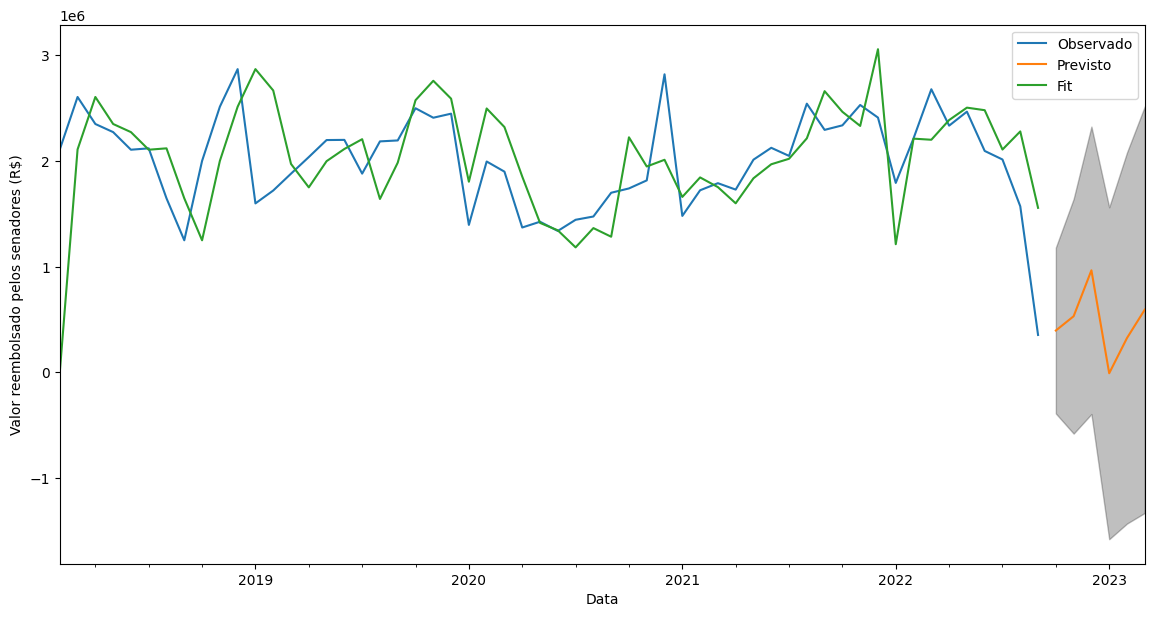

In [117]:
#Previsões considerando 6 passos depois dos dados fitados
pred_uc = results.get_forecast(steps=6)

#intervalo de confiança das previsões
pred_ic = pred_uc.conf_int()

#plot
ax=y.plot(label='Observado', figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax, label='Previsto')
results.fittedvalues.plot(ax=ax, label='Fit')
ax.fill_between(pred_ic.index, pred_ic.iloc[:,0], pred_ic.iloc[:,1], color='k', alpha=0.25)
ax.set_xlabel('Data')
ax.set_ylabel('Valor reembolsado pelos senadores (R$)')
plt.legend()
plt.show()

In [118]:
y.iloc[1:2].index[0]

Period('2018-03', 'M')

#### Cross Validation

Faremos uma validação denominada cross-validation que consiste em:

    1) Fitar um modelo em uma amostra para treino.
    2) Efetuar a previsão para n passos.
    3) Expandir a amostra para incluir o próximo observável.
    4) Calcular os erros das previsões, erros relativos aos valores verdadeiros do 
    dataset.
Então repetiremos isso recursivamente.


In [119]:
# Setup forecasts
#Faremos previsões considerando 3 passos
nforecasts = 3
forecasts = {}

#Escolheremos o treino inicial como 80% dos dados
nobs = len(y)
n_init_training = int(nobs * 0.8)
training_y = y.iloc[:n_init_training]

#1) Fitar um modelo em uma amostra para treino.
mod = sm.tsa.statespace.SARIMAX(training_y,order = (0, 1, 0),seasonal_order=(1, 1, 0, 12))
res = mod.fit()
    
#2) Efetuar a previsão para n passos escolhidos
forecasts[training_y.index[-1]] = res.forecast(steps=nforecasts)

# Repete para toda a amostra
for t in range(n_init_training, nobs):
    #3) Expandir a amostra para incluir o próximo observável.
    updated_y = y.iloc[t:t+1]
    res = res.append(updated_y, refit=False)
    #Salvando o conjunto de previsões
    forecasts[updated_y.index[0]] = res.forecast(steps=nforecasts)
# Combinando as previsões em um dataframe
forecasts = pd.concat(forecasts, axis=1)

# 4) Calcular os erros das previsões, erros relativos aos valores verdadeiros do dataset.
forecast_errors = forecasts.apply(lambda column: y - column).reindex(forecasts.index)
forecast_errors.index=forecast_errors.index.rename('Forecasted')
forecast_errors


,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09
Forecasted,,,,,,,,,,,,,
2021-10,-115178.696811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11,75066.646697,190245.343508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12,-618861.590169,-503682.893358,-693928.236866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01,NaN,90418.006185,-99827.337323,5.941009e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02,NaN,NaN,-79612.146623,6.143161e+05,20215.190700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03,NaN,NaN,NaN,1.084300e+06,490198.667186,469983.476485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04,NaN,NaN,NaN,NaN,414390.010790,394174.820090,-75808.656396,NaN,NaN,NaN,NaN,NaN,NaN
2022-05,NaN,NaN,NaN,NaN,NaN,345033.248292,-124950.228193,-49141.571797,NaN,NaN,NaN,NaN,NaN
2022-06,NaN,NaN,NaN,NaN,NaN,NaN,-520234.806269,-444426.149873,-3.952846e+05,NaN,NaN,NaN,NaN


In [120]:
# Mudando os indíces de forecasted para horizonte, de modo que, para cada data, mostraremos apenas 
#os 3 valores previstos
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizonte')

df_flattened=pd.DataFrame(flattened)
flattened

,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09
horizonte,,,,,,,,,,,,,
1,-115178.696811,190245.343508,-693928.236866,5.941009e+05,20215.190700,469983.476485,-75808.656396,-49141.571797,-3.952846e+05,-8.547170e+04,-7.310620e+05,-1.179831e+06,NaN
2,75066.646697,-503682.893358,-99827.337323,6.143161e+05,490198.667186,394174.820090,-124950.228193,-444426.149873,-4.807563e+05,-8.165337e+05,-1.910893e+06,NaN,NaN
3,-618861.590169,90418.006185,-79612.146623,1.084300e+06,414390.010790,345033.248292,-520234.806269,-529897.854620,-1.211818e+06,-1.996365e+06,NaN,NaN,NaN


In [121]:
#Calculando o rms do erro, ou seja, o rmse
rmse = (flattened**2).mean(axis=1)**0.5
df_rmse=pd.DataFrame(rmse)
df_rmse

,0
horizonte,
1,516673.244646
2,726438.565059
3,887095.672812


In [122]:
rmse.mean()

710069.1608389966

Com isso temos que a média do rms dos erros, dados pelo cross validation calculado, foi de aproximadamente 0.7 milhões de reais. O que nos ajuda como uma estimativa dos erros do nosso modelo.